In [1]:
# very similar to the code in "figure 6 w heatmap.ipynb", but this notebook finds heatmaps for cloud height (not w) vs rmw

In [3]:
# import...
import numpy as np
import xarray as xr
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import math
import scipy
import sys
import warnings
import pandas as pd
from scipy.signal import find_peaks

sys.path.append("/Users/etmu9498/research/code/scripts-winter2023")
import helper_fns_winter2023 as helper_fns
import helpful_stats
sys.path.append("/Users/etmu9498/research/code/scripts-winter2023/cloud-top-height-stats")
import find_cloud_tops
import eyewall_metadata

In [4]:
# the function below has been taken from "code/scripts-winter2023/fl-data-compositing/fl_mean_cloud_heights.py"

# like other flight level datasets, calculate the mean cloud height vs rmw!
# use the crl data instead of flight level data
def calc_cloud_heights_rmws( tc='all', eye_limits='default', binwidth=.1, maxbin=10, bintype='rmw', fl_rmw = True):
    crl_data_root = "/Users/etmu9498/research/data/crl-all-data-processed/"
    yearlist, filelist = helper_fns.get_crl_datasets( tc)
   
    # load eyewall limits from helper function
    metadata = eyewall_metadata.all_metadata( eye_limits=eye_limits)

    # print out the number of files to be saved
    filecount = 0
    for yeari in range( len( filelist)):
        # count all the names in this year, and add to the count
        filecount += len( filelist[ yeari])
    print("Number of crl files to be added: " + str( filecount))

    # initialize a new dataframe to save binned data
    # do this outside the main loop to store all values in the same dataframe
    df_new_bins = pd.DataFrame( )

    # make an array representing the bins!
    bins = np.arange(0, maxbin, step=binwidth)
    # create an array of midpoints (right between two given binwidths)
    midpoints = []
    for i in range( len( bins) - 1):
        midpoints.append( (bins[ i] + bins[ i+1]) / 2)
    midpointarray = np.array( midpoints)

    # add midpoints and bins to the data array
    df_new_bins[ 'bins'] = bins[ 0: len( bins)-1] # drop last value for correct array size
    df_new_bins[ 'midpoints'] = midpoints
    nancount = 0

    # initial value, update later!
    cloud_heights_df = []
    p3_heights_df = []
    # initial case: make a bunch of empty lists in cloud_heights_df and p3_heights_df!
    # will be filled below in for loops.
    # make empty lists for midpoints
    for j in range( len( midpoints)):
        cloud_heights_df.append([])
        p3_heights_df.append([])

    # do this for all the datasets! years and filenames
    for yeari, yearval in enumerate( yearlist):
        for filei, fileval in enumerate( filelist[ yeari]):
            print(fileval)
            
            # get data
            crl_path = crl_data_root + yearval
            os.chdir( crl_path)
            crl_data = xr.open_dataset( fileval)

            date = fileval[7:11]
            # check if this date exists... if not, give it some empty eyewall limits!
            # also account for fred am and pm cases!!
            if date == '0812':
                if fileval[11:13] == "H1":
                    eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812am']
                elif fileval[11:13] == "H2":
                    eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812pm']
            elif date in metadata[ yearval]['eyewall_limits'].keys():
                eyewall_limits = metadata[ yearval]['eyewall_limits'][ date]
            else:
                eyewall_limits = [ ()]       
            # make sure intensity metadata are inputed for this year!
            if len( metadata[yearval]['intensity'].keys() ) > 0:
                if date == '0812':
                    if fileval[11:13] == "H1":
                        intensity = metadata[ yearval]['intensity'][ '0812am']
                    elif fileval[11:13] == "H2":
                        intensity = metadata[ yearval]['intensity'][ '0812pm']
                elif date in metadata[ yearval]['intensity'].keys():
                    intensity = metadata[yearval]['intensity'][date]
                else:
                    print( metadata[ yearval]['intensity'].keys())
                    intensity = 0
            else:
                intensity = 0
            
            # do this for each of the eyewall limit pairs! Can have multiple eyes per crl dataset
            for eyei, eyeval in enumerate( eyewall_limits):
                # do all of the appending in this if statement- eliminate cases without valid eyewalls!
                if len( eyeval) > 0:
                    # find the corresponding FLIGHT LEVEL!! indices to the time limits
                    ind0 = np.argmin( np.abs(crl_data.time.values - eyeval[0] ))
                    ind1 = np.argmin( np.abs(crl_data.time.values - eyeval[1] ))

            
                    # save all relevant fields as numpy arrays rather than xarray: saves computing time!
                    # old code: get rid of if bintype == 'rmw' code below and uncomment: 
                    # rmwvals = crl_data['rmw'][ind0:ind1].values
                    p3_heightvals = crl_data['p3_height'][ind0:ind1].values

                    # new code: now able to use rmw or distance bins! 
                    if bintype == 'rmw':
                        # normal case: use the .trak derived distances and rmws to bin the data
                        if fl_rmw:
                            rmwvals = crl_data['rmw'][ind0:ind1].values
                        else:
                            # alternate case: initialize an evenly spaced "rmw" array from one eyewall limit to another! for every case
                            total_list = []
                            # figure out the correct length of the new array... different for even and odd cases
                            # even case: split distances down the middle. add zero point on second created array (ex 0 ->1)
                            if (ind1-ind0) % 2 == 0:
                                len0 = int( ( ind1 - ind0) / 2 + 1 )
                                len1 = int( ( ind1 - ind0) / 2 )
                                # add the first part of the array (1->0)
                                total_list += np.linspace(1, 0, num=len0).tolist()
                                # get rid of the first array's zero (so no duplicates)
                                total_list = total_list[:-1]
                                # add the second rmw array (0->1)
                                total_list += np.linspace(0, 1, num=len1).tolist()
                                
                            # odd case: leave out center ind from len0 and len1, make this point the 0 mark!
                            else:
                                # round up the half lengths
                                len0 = int( math.ceil( ( ind1 - ind0) / 2 ))
                                len1 = int( math.ceil( ( ind1 - ind0) / 2 ))
                                # add the first array
                                total_list += np.linspace(1, 0, num=len0).tolist()
                                # get rid of the first array's zero (so no duplicates)
                                total_list = total_list[0:len(total_list)-1]                                
                                # add the second rmw array (0->1)
                                total_list += np.linspace(0, 1, num=len1).tolist()
                            # make the newly created total_list the new rmw array!
                            rmwvals = np.array(total_list)
                            
                    # alternate case: use the .trak derived distances, not the rmw values!
                    elif bintype == 'dist':
                        if fl_rmw:
                            rmwvals = crl_data['center_dist'][ind0:ind1].values
                        # there's no good / useful way to automatically bin distance data using crl limits... so print an error message for this case!
                        else:
                            print("please select fl_rmw=True when using the radial distance axis!")

                    # find cloud heights for this case!
                    H = crl_data.height
                    power = crl_data.P_ch1[ind0:ind1, :]
                    axis = crl_data.time[ind0:ind1]
                    p3_height = crl_data.p3_height[ind0:ind1]
                    if yearval == '2021':
                        min = -30
                    elif yearval == '2022':
                        min = -40
                        
                    cloudheights, cloudtime = find_cloud_tops.find_cloud_heights( H, power, axis, p3_height, cutoff_power = min)
                    print("Cloud heights found")

                    # sort through every rmw axis value for a given eye pass: check if it's within the bin!
                    for rmw_i, rmw_val in enumerate( rmwvals ):
                        # do nothing for nans
                        if np.isnan( rmw_val):
                            nancount += 1
                        else:
                            # new method: use array subtraction to find the closest midpoint to the given rmw_i
                            bin_i = np.argmin( np.abs( midpointarray - rmw_val ))
                            
                            # add the singular value for this variable to the correct spot in the total binned array
                            # only do this if the height is above 150 m!
                            if cloudheights[ rmw_i] > 150.:
                                cloud_heights_df[ bin_i].append( cloudheights[ rmw_i])
                            else:
                                cloud_heights_df[bin_i].append( np.nan)
                            
                            # add the p3 height at this point to a similar array
                            p3_heights_df[ bin_i].append( p3_heightvals[ rmw_i])

    df_new_bins['cloud_heights'] = cloud_heights_df
    df_new_bins['p3_heights'] = p3_heights_df

    print( "Cloud and P-3 Heights Added to Dataframe")

    '''
    # calculate confidence intervals for the new cloud height variables
    var_mean, var_lowc, var_highc = [], [], []
    p3_mean = []
    field = df_new_bins[ 'cloud_heights']

    # do this for every bin for that variable
    for i in range( len( df_new_bins[ 'midpoints'] )):
        mean, lowc, highc = helpful_stats.t_test_intervals( field[i], confidence=confidence)
        var_mean.append(  mean)
        var_lowc.append(  lowc)
        var_highc.append(  highc)
        p3_mean.append( np.mean(df_new_bins['p3_heights'][i]))

    # after going through every pass for this variable, add the results to the dataframe!
    df_new_bins["cloud_heights_mean"] = var_mean
    df_new_bins["cloud_heights_highc"] = var_highc
    df_new_bins["cloud_heights_lowc"] = var_lowc
    df_new_bins['p3_heights_mean'] = p3_mean
    print( "Means and Confidence Intervals Found")
    '''
    
    return df_new_bins

In [5]:
# return a dictionary of crl names to input into the cloud height script!
# this allows for sorting by intensity, intensification, etc
def group_crl_data(year='all', sort_type='intensity', sort_for='NA', eye_limits='default'):
    crl_data_root = "/Users/etmu9498/research/data/crl-all-data-processed/"
    yearlist, filelist = helper_fns.get_crl_datasets( year)

    # load eyewall limits from helper function
    metadata = eyewall_metadata.all_metadata( eye_limits=eye_limits)

    returndict = {}
    
    # do this for all the datasets! years and filenames
    for yeari, yearval in enumerate( yearlist):
        returndict[yearval] = []
        
        for filei, fileval in enumerate( filelist[ yeari]):
            
            date = fileval[7:11]            
            # make sure intensity metadata are inputed for this year!
            if len( metadata[yearval]['category'].keys() ) > 0:
                if date == '0812':
                    if fileval[11:13] == "H1":
                        category = metadata[ yearval]['category'][ '0812am']
                    elif fileval[11:13] == "H2":
                        category = metadata[ yearval]['category'][ '0812pm']
                elif date in metadata[ yearval]['category'].keys():
                    category = metadata[yearval]['category'][date]
                else:
                    print( metadata[ yearval]['category'].keys())
                    category = 0
            else:
                category = 0
                            
            # default case: make sure the user enters a proper tag, not just NA
            if category == 'NA':
                print("Please select a valid intensity or intensification category!")
                return returndict
            # this case falls into the correct intensity / intensification / specifier! add it to the return dictionary
            if category == sort_for:
                returndict[yearval] = returndict[yearval] + [fileval]
                
    return returndict     


In [10]:
def plot_cloud_heatmap(df_cloud, cloud_binwidth=250., normalize=False, log=False, strength='all', axis='rmw'):
    cloudheights = df_cloud['cloud_heights']

    # add upper limits for each case, and space the contour levels nicely for each case
    cbar_lims = 400
    levels = np.arange(0, cbar_lims, step=40)        
    plt.figure( figsize=(8, 4))
    nancount = 0
    fs=11
    helper_fns.change_font_sizes(fs, fs)

    # find the lowest and highest values for all the bins... need to convert the list of lists into one flat list!!
    tcfield_list = []
    for fieldi, fieldval in enumerate( cloudheights):
        tcfield_list += fieldval
        
    if len(tcfield_list) == 0:
        print("No valid cases for " + strength)
        return
    minval = np.nanmin( tcfield_list)
    maxval = np.nanmax( tcfield_list) 

    # define the x and y axes
    rmws = df_cloud[ 'midpoints']
    bins = np.arange( math.floor( minval) - 2*cloud_binwidth, math.ceil( maxval)+ 2*cloud_binwidth, step=cloud_binwidth)

    # save the data count here!
    count_density = np.zeros( [ len( rmws), len( bins)])

    # do this for every rmw bin
    for rmw_i, rmwval in enumerate( rmws):
        # get the local array for this bin
        ch_current = cloudheights[ rmw_i]

        # do this for every value in the locally defined tc field!
        for tcfieldi, tcfieldval in enumerate( ch_current):
            # find the closest bin for this value
            # negative values after subtraction means we've gone too low: take the lowest positive value
            minusarray = bins - tcfieldval 

            # make sure to not index by an empty list!
            if np.all( np.isnan( minusarray)):
                nancount += 1
            else:            
                # find the correct bin index, bin_i, for the closest bin
                # the first [0] looks at the array, and the second [0] takes the first value.
                # The first value is always the smallest!                
                try:
                    bin_i = np.where( minusarray >= 0.0)[0][0]
                    # add one to the nearest bin in the total array!
                    count_density [ rmw_i] [bin_i] += 1
                except:
                    print( minusarray)

    # make the plot!
    color_map = plt.cm.get_cmap( "RdYlBu").reversed()

    # try normalizing the bin count so the plot is smoother
    if normalize:
        # do this for every rmw / distance
        for radius_i in range(np.shape(count_density)[0]):
            
            # locally define the row of cloud height probabilities for this given radial distance
            # leaving the variables named as w here, but they really represent cloud heights!
            w_row = count_density[radius_i, :]
            # count the number of w values for each given w limit (.2-.3, .3-.4 m/s, etc) at this radial distance
            w_sum = 0
            for wi in w_row:
                w_sum += wi   
            # the value to divide all counts by at this radial distance: w_sum_i / divideval = 100 (%)
            divideval = w_sum / 100
            # scale the count density axis!
            count_density[radius_i, :] = w_row / divideval
            
            # testing: the new w_sum here should = 100 for all cases!
            # w_row = count_density[radius_i, :]
            # w_sum = 0
            # for wi in w_row:
            #     w_sum += wi
            # print(w_sum)

        # make the normalized plot
        cbar_lims = 20
        levels = np.linspace(0, cbar_lims, num=10)
        
        if log:
            plt.pcolormesh( rmws, bins, count_density.transpose(), cmap = color_map,  norm=colors.LogNorm(vmin=0.01, vmax=cbar_lims)) # vmin = 0, vmax = cbar_lims, )
            # plt.contourf( rmws, bins, count_density.transpose(), levels, cmap = color_map, extend='both')              
            savename = 'cloud-heatmap-percent-' + strength + '-log.png'
        else:
            plt.pcolormesh( rmws, bins, count_density.transpose(), cmap = color_map, vmin = 0, vmax = cbar_lims, )
            # plt.contourf( rmws, bins, count_density.transpose(), levels, cmap = color_map, extend='both')              
            savename = 'cloud-heatmap-percent-' + strength + '.png'
            
        plt.colorbar(label = 'Bin Likelihood (%)')

    # don't normalize case: just plot a bin count at each w bin and rmw!
    else:
        plt.pcolormesh( rmws, bins, count_density.transpose(), cmap = color_map, vmin = 0, vmax = cbar_lims) # vmin = minval - 2 * binsize[ i], vmax = maxval + 2*binsize[ i])
        # plt.contourf( rmws, bins, count_density.transpose(), levels, cmap = color_map, extend='both')  
        plt.colorbar(label = 'Bin Count')
        savename = 'cloud-heatmap-count.png'

    # plot the mean cloud height at each radial distance!
    meanh = []
    hlist = df_cloud.cloud_heights.values
    for j in range( len( hlist)):
        meanh.append(np.nanmean(hlist[j]))

    plt.plot(rmws, meanh, c='k', linewidth=3, label='Mean Height')
    leg = plt.legend( fancybox=False, shadow=False, fontsize=fs, facecolor='w', framealpha=1)
    leg.get_frame().set_linewidth( 1.5) 
    leg.get_frame().set_edgecolor('k')

    plt.title('Cloud Height vs RMW distributions for ' + strength.upper() + ' cases')
    plt.ylabel( 'Cloud Height (m)')
    
    if axis == 'rmw':
        plt.xlabel( 'RMW')
        plt.xlim([0, 1])
    elif axis == 'dist':
        plt.xlabel( 'Distance (Km)')
        plt.xlim([0, 50])
        
        
    # save the final figure!
    os.chdir( "/Users/etmu9498/research-private/eye-cloud-paper")
    plt.savefig( savename, bbox_inches='tight', dpi=500, transparent=False )

Number of crl files to be added: 1
P3_20210926H1_processed.nc
Cloud heights found
Cloud heights found
Cloud heights found
Cloud and P-3 Heights Added to Dataframe


C:\Users\etmu9498\AppData\Local\Temp\ipykernel_25412\2093404752.py:73: RuntimeWarning: invalid value encountered in divide
  count_density[radius_i, :] = w_row / divideval
C:\Users\etmu9498\AppData\Local\Temp\ipykernel_25412\2093404752.py:108: RuntimeWarning: Mean of empty slice
  meanh.append(np.nanmean(hlist[j]))


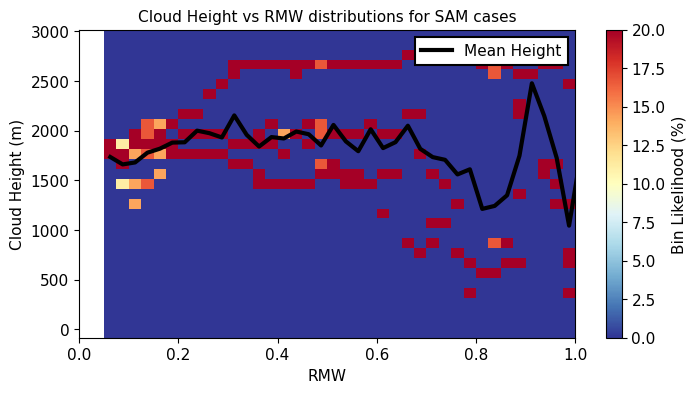

In [13]:
# make a heatmap for just TC sam individual dates!
# to change raw colormesh vs interpolated colors, 

inputdict={}
inputdict['2021'] = ['P3_20210926H1_processed.nc'] # , 'P3_20210927H1_processed.nc', 'P3_20210929H2_processed.nc']
intensityval = 'sam'
bw = 100 # cloud (y axis) binwidth

# using distance
# df = calc_cloud_heights_rmws( tc=inputdict, binwidth=2.5, maxbin=50, bintype='dist', fl_rmw = True)
# plot_cloud_heatmap( df, normalize=True, cloud_binwidth=bw, log=False, strength=intensityval, axis='dist')

# using rmw-  from .trak files (fl_rmw=True)
df = calc_cloud_heights_rmws( tc=inputdict, binwidth=.025, maxbin=1.5, bintype='rmw', fl_rmw = True)
plot_cloud_heatmap( df, normalize=True, cloud_binwidth=bw, log=False, strength=intensityval, axis='rmw')

# using rmw- from a standard -1 to 1 (fl_rmw=False)
# df = calc_cloud_heights_rmws( tc=inputdict, binwidth=.025, maxbin=1.5, bintype='rmw', fl_rmw = False)
# plot_cloud_heatmap( df, normalize=True, cloud_binwidth=bw, log=False, strength=intensityval, axis='rmw')

In [18]:
# run the code below to create separate dataframes for each intensity! 
# will be useful for making separate figures (mean, colormap) below

# store dataframes in this list
data_list = []
intensity_list = ['td', 'ts', 'wh', 'sh']
for intensity in intensity_list:
    # use the helper function defined above to get filenames for this intensity!
    names = group_crl_data(year='all', sort_for=intensity)
    print('Current Intensity: ' + intensity)
    print('Valid Cases: ' + str( names['2021'] + names['2022']))
    
    # add the dataframe to the output data_list!
    
    # distance case:
    # data_list.append( calc_cloud_heights_rmws( tc=names, binwidth=2., maxbin=55., bintype='dist', fl_rmw = True))   
    
    # rmw using .trak data case:
    # data_list.append( calc_cloud_heights_rmws( tc=names, binwidth=.025, maxbin=1.5, bintype='rmw', fl_rmw = True))   
    
    # rmw using normalized (-1 to 1) axis
    data_list.append( calc_cloud_heights_rmws( tc=names, binwidth=.025, maxbin=1.5, bintype='rmw', fl_rmw = False))   

Current Intensity: td
Valid Cases: ['P3_20210811H1_processed.nc', 'P3_20210812H1_processed.nc', 'P3_20210812H2_processed.nc', 'P3_20210813H1_processed.nc', 'P3_20210816H1_processed.nc', 'P3_20220830H1_processed.nc']
Number of crl files to be added: 6
P3_20210811H1_processed.nc
P3_20210812H1_processed.nc
Cloud heights found
Cloud heights found
Cloud heights found
P3_20210812H2_processed.nc
Cloud heights found
Cloud heights found
P3_20210813H1_processed.nc
Cloud heights found
Cloud heights found
P3_20210816H1_processed.nc
Cloud heights found
Cloud heights found
P3_20220830H1_processed.nc
Cloud and P-3 Heights Added to Dataframe
Current Intensity: ts
Valid Cases: ['P3_20210817H1_processed.nc', 'P3_20210819H1_processed.nc', 'P3_20210820H1_processed.nc', 'P3_20220905H1_processed.nc', 'P3_20220906H1_processed.nc', 'P3_20220916H1_processed.nc', 'P3_20220917H1_processed.nc', 'P3_20220918H1_processed.nc', 'P3_20220924H1_processed.nc', 'P3_20220925H1_processed.nc', 'P3_20221008H1_processed.nc']


Case td


C:\Users\etmu9498\AppData\Local\Temp\ipykernel_25412\2093404752.py:73: RuntimeWarning: invalid value encountered in divide
  count_density[radius_i, :] = w_row / divideval
C:\Users\etmu9498\AppData\Local\Temp\ipykernel_25412\2093404752.py:108: RuntimeWarning: Mean of empty slice
  meanh.append(np.nanmean(hlist[j]))


Case ts
Case wh
Case sh


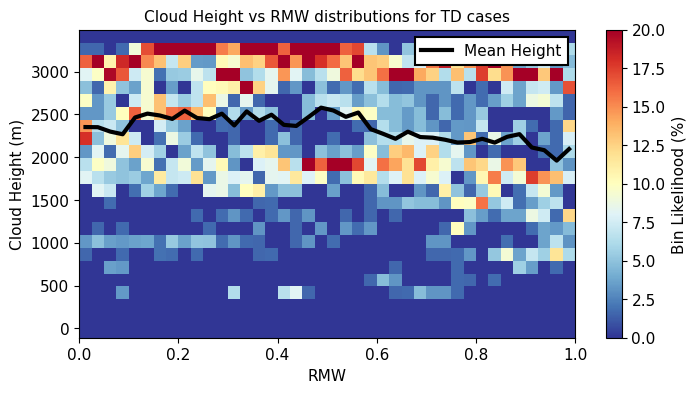

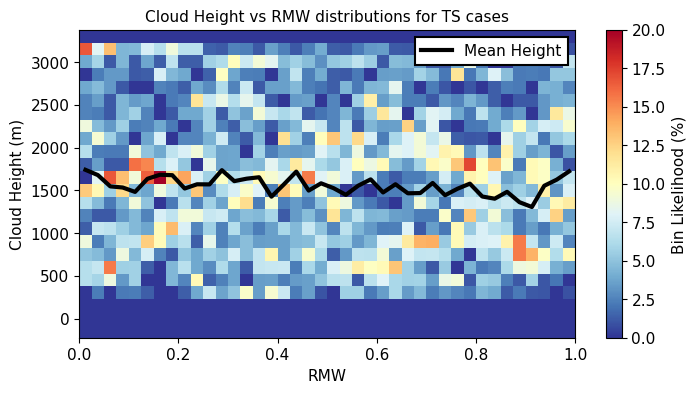

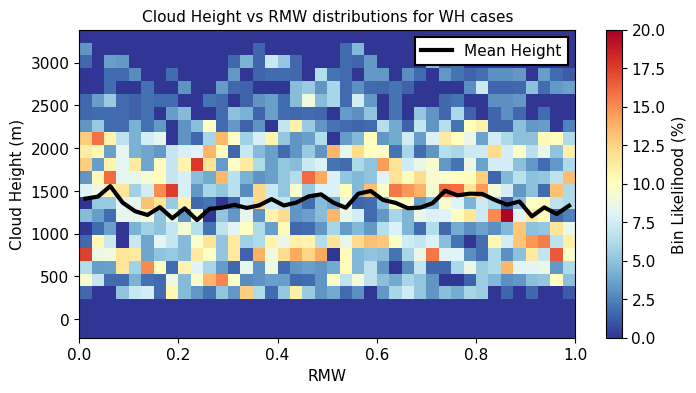

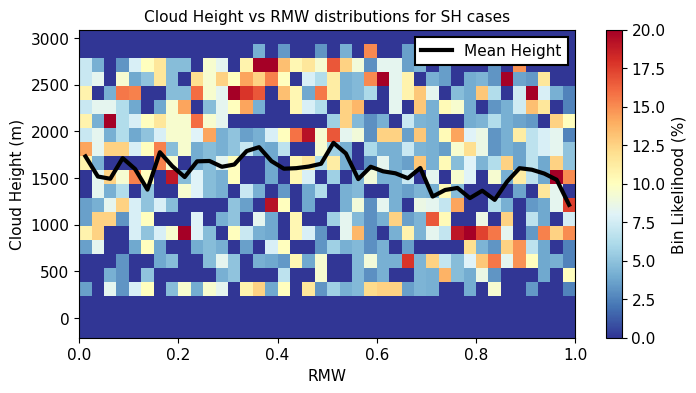

In [19]:
# create plots for each of the intensities specified above!
intensity_list = ['td', 'ts', 'wh', 'sh']
for i, intensityval in enumerate( intensity_list):
    print("Case " + intensityval)
    
    # distance case
    # plot_cloud_heatmap( data_list[i], normalize=True, cloud_binwidth=150, log=False, strength=intensityval, axis='dist')
    # rmw case
    plot_cloud_heatmap( data_list[i], normalize=True, cloud_binwidth=150, log=False, strength=intensityval, axis='rmw')
    

In [35]:
# print out basic info about the new data_list
print(len(data_list))
print(np.shape(data_list[0]))
for i in range(4):
    print(intensity_list[i])
    print( len( data_list[i].cloud_heights))
    
    # print the average cloud height at each radial distance!
    hlist = data_list[i].cloud_heights.values
    meanh = []
    for j in range( len( hlist)):
        # print(np.nanmean(hlist[j]))
        meanh.append(np.nanmean(hlist[j]))
        
    print(len(meanh))

4
(59, 4)
td
59
59
ts
59
59
wh
59
59
sh
59
59


C:\Users\etmu9498\AppData\Local\Temp\ipykernel_29100\1914806423.py:13: RuntimeWarning: Mean of empty slice
  meanh.append(np.nanmean(hlist[j]))


In [ ]:
# try to write some code here that plots the radial time series values for each cloud height P-3 pass!
# like just plot lines on top of one another to get a better sense of the cloud field variance.

# also try adding mean height lines to the rmw plots shown above!